# **Задачи к курсу и решения к ним**

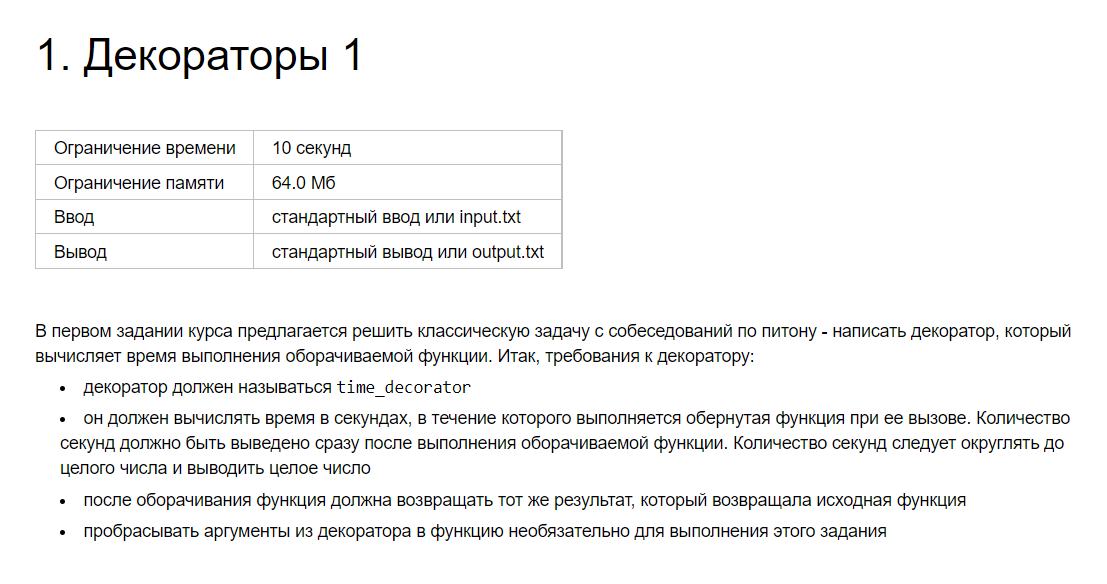

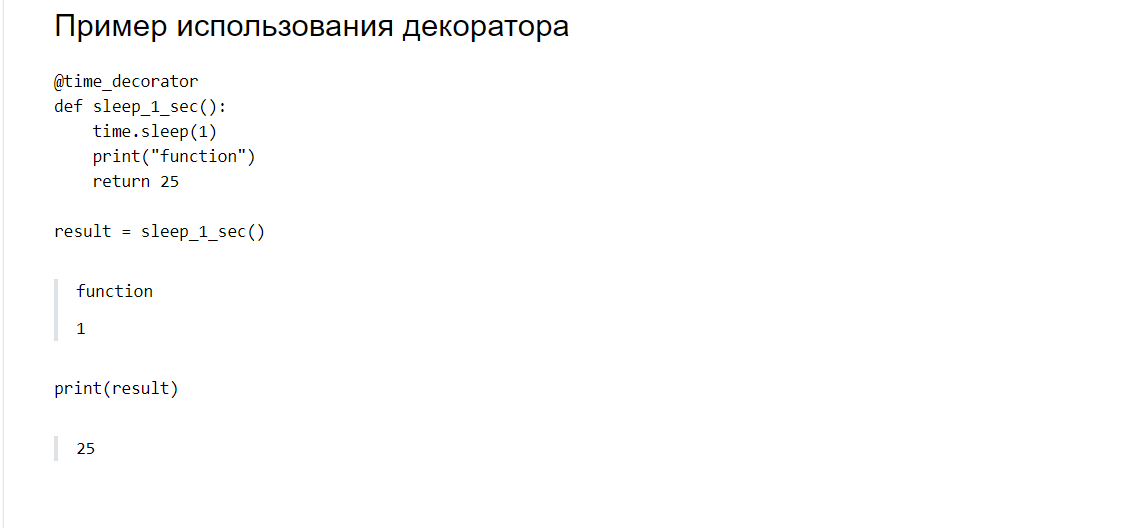

Решение

In [ ]:
import time

def time_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        
        result = func(*args, **kwargs)
        
        ends_time = time.time()
        time_work = ends_time - start_time
        time_work_int = round(time_work)
        print(time_work_int)
        
        return result
    return wrapper

Тестирование

In [ ]:
@time_decorator
def sleep_1_sec():
    time.sleep(1)
    print("function")
    return 25

result = sleep_1_sec()

function
1


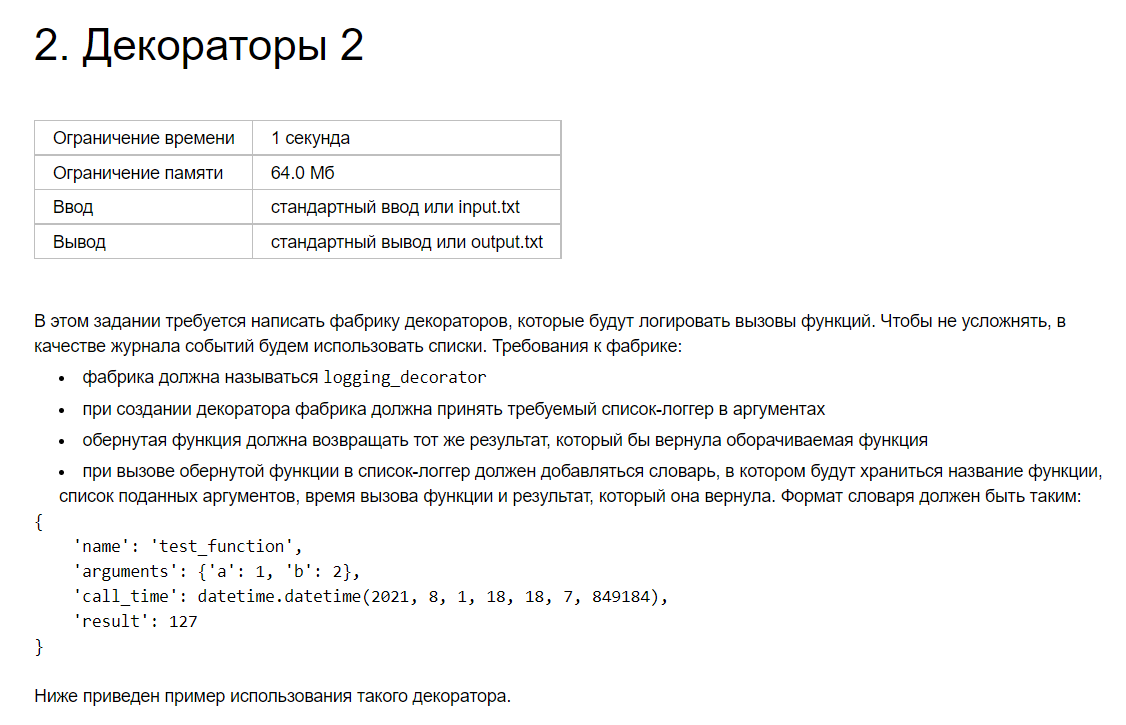

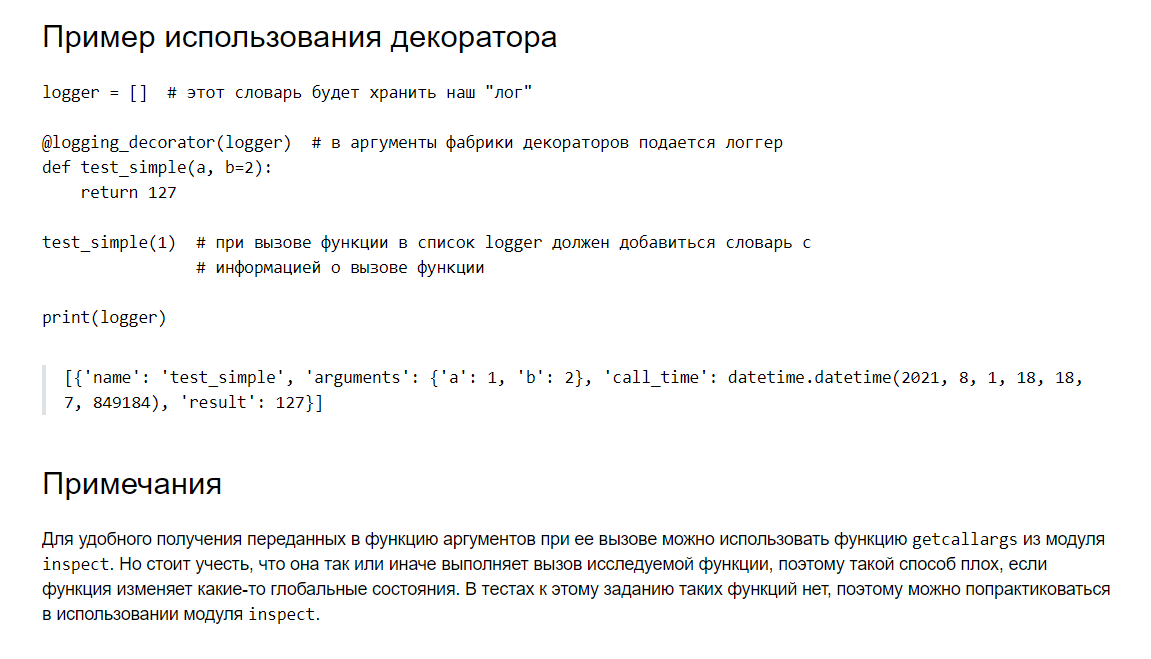

Решение

In [ ]:
from inspect import getcallargs 
import datetime 

def logging_decorator(logger):
  def decorator(func):
    def wrapper(*args, **kwargs):
      
      my_dict = {'name' : func.__name__,
                'arguments' : getcallargs(func, *args, **kwargs)} 
      
      my_dict['call_time'] = datetime.datetime.now()
      result = func(*args, **kwargs)
      my_dict['result'] = result

      logger.append(my_dict)

      return result
    return wrapper
  return decorator

Тест 1

In [ ]:
logger = []

@logging_decorator(logger)
def result(a, b):
  print('result')

result(1, b = 2)
logger

result


[{'arguments': {'a': 1, 'b': 2},
  'call_time': datetime.datetime(2021, 12, 4, 14, 37, 49, 493166),
  'name': 'result',
  'result': None}]

Тест 2

In [ ]:
logger = []  # этот словарь будет хранить наш "лог"

@logging_decorator(logger)  # в аргументы фабрики декораторов подается логгер
def test_simple(a, b=2):
    return 127

test_simple(1)  # при вызове функции в список logger должен добавиться словарь с
                # информацией о вызове функции

print(logger)

(1,)
[{'name': 'test_simple', 'arguments': {'a': 1, 'b': 2}, 'call_time': datetime.datetime(2021, 12, 4, 14, 35, 39, 409345), 'result': 127}]


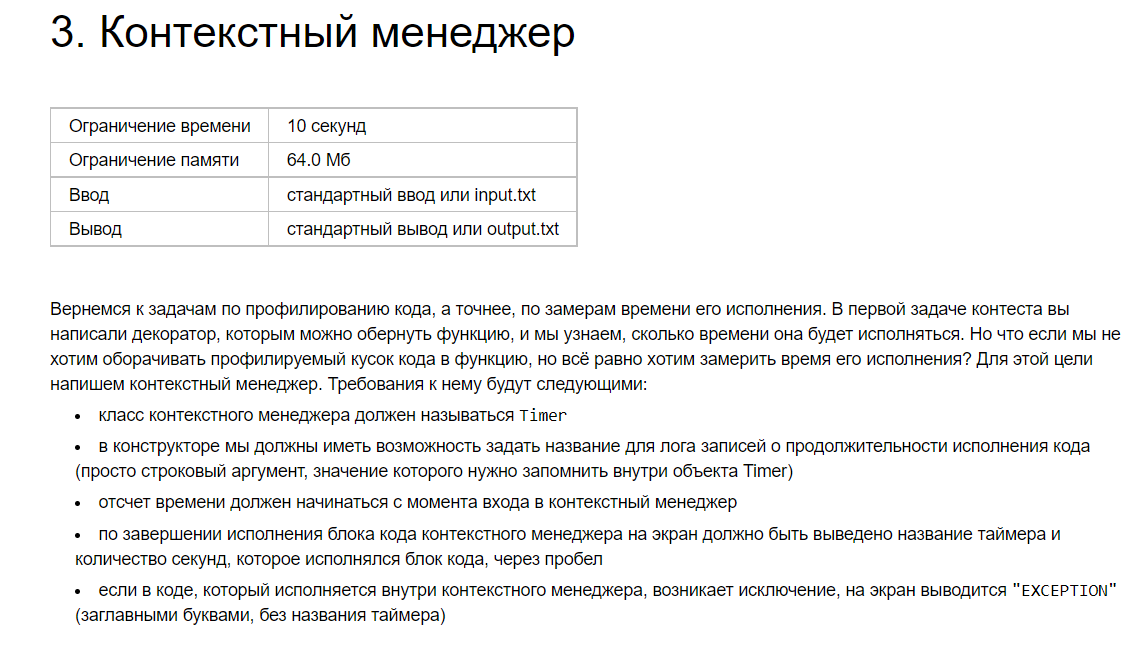

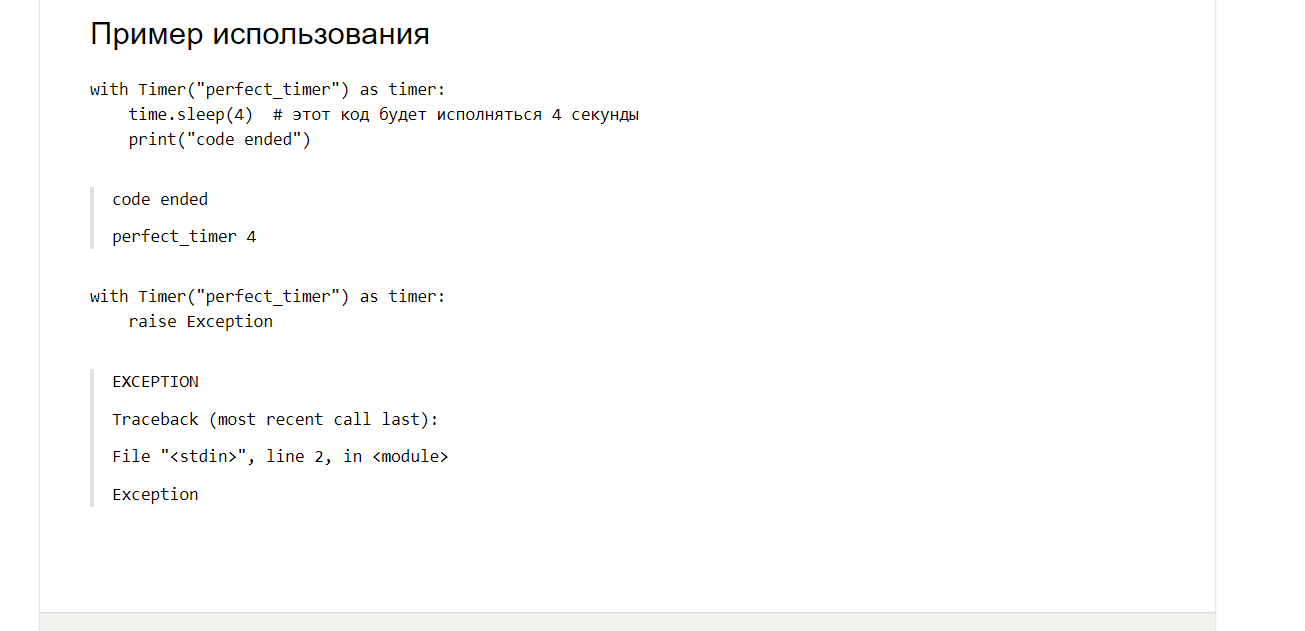

Задание

In [ ]:
import time

class Timer:
  def __init__(self, name):
    self.name = name

  def __enter__(self):
    self.start_time = time.time()

  def __exit__(self, type_, value, traceback):
    if type_ is not None and issubclass(type_, Exception):
      print("EXCEPTION")
    else:
      time_work = round(time.time() - self.start_time)
      print(self.name, str(time_work))
      return True        

Тест №1

In [ ]:
with Timer("perfect_timer") as timer:
    time.sleep(1)  # этот код будет исполняться 4 секунды
    print("code ended")

code ended
perfect_timer 1


Тест №2

In [ ]:
with Timer("perfect_timer") as timer:
    raise ValueError

EXCEPTION


ValueError: ignored

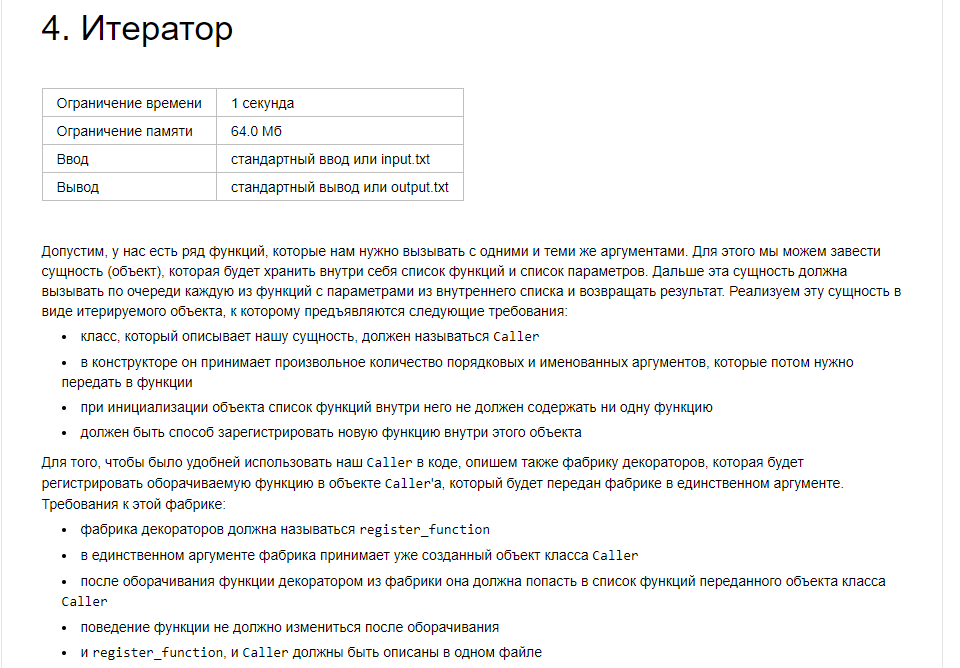

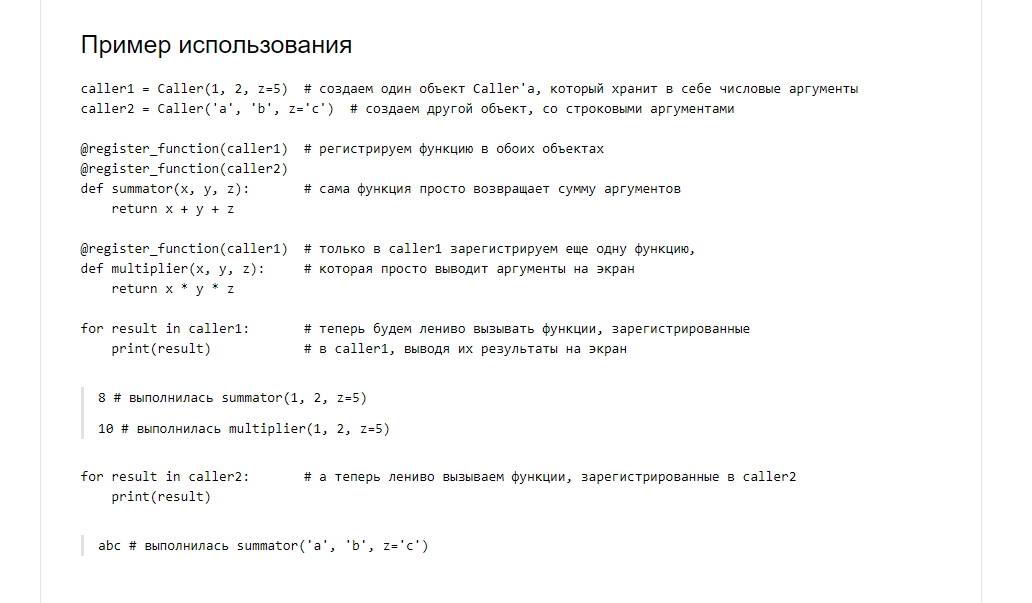

Решение

In [ ]:
class Caller():
  
  def __init__(self, *args, **kwargs):
    self.args = (args, kwargs) 
    self.counter = 0
    self.list_function = []

  def __iter__(self):
    return self

  def __next__(self):
    if self.counter < len(self.list_function):
      results = self.list_function[self.counter](*self.args[0], **self.args[1])
      self.counter += 1
      return results
    else:
      raise StopIteration

  def reg_fun(self, func):
    self.list_function.append(func)

def register_function(caller):
  def decorator(func):
    caller.reg_fun(func)	
    def wrapper(*args, **kwargs):
      result = func(*args, **kwargs)
      return result
    return wrapper  
  return decorator

Тест 1

In [ ]:
caller = Caller(a=1,b=2)

@register_function(caller)
def func(a,b):
  return a + b

@register_function(caller)
def func(a,b):
  return a - b

for result in caller:
  print(result)

3
-1


Тест 2

In [ ]:
caller1 = Caller(1, 2, z=5)  # создаем один объект Caller'а, который хранит в себе числовые аргументы
caller2 = Caller('a', 'b', z='c')  # создаем другой объект, со строковыми аргументами

@register_function(caller1)  # регистрируем функцию в обоих объектах  
@register_function(caller2)
def summator(x, y, z):       # сама функция просто возвращает сумму аргументов
    return x + y + z

@register_function(caller1)  # только в caller1 зарегистрируем еще одну функцию,
def multiplier(x, y, z):     # которая просто выводит аргументы на экран
    return x * y * z

for result in caller1:       # теперь будем лениво вызывать функции, зарегистрированные
    print(result)            # в caller1, выводя их результаты на экран
8 # выполнилась summator(1, 2, z=5)

10 # выполнилась multiplier(1, 2, z=5)

for result in caller2:       # а теперь лениво вызываем функции, зарегистрированные в caller2
    print(result)


8
10
abc


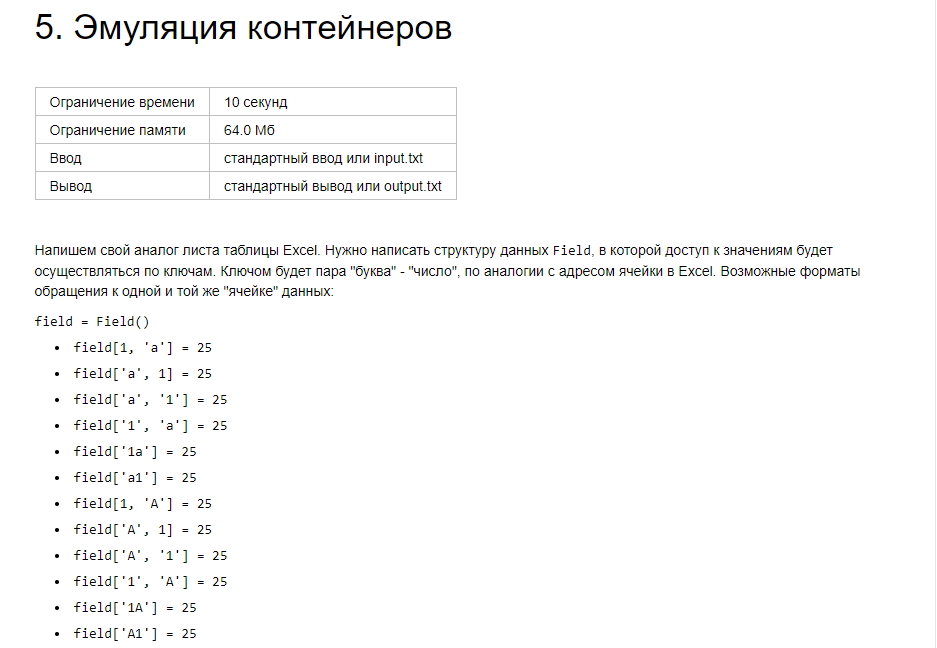

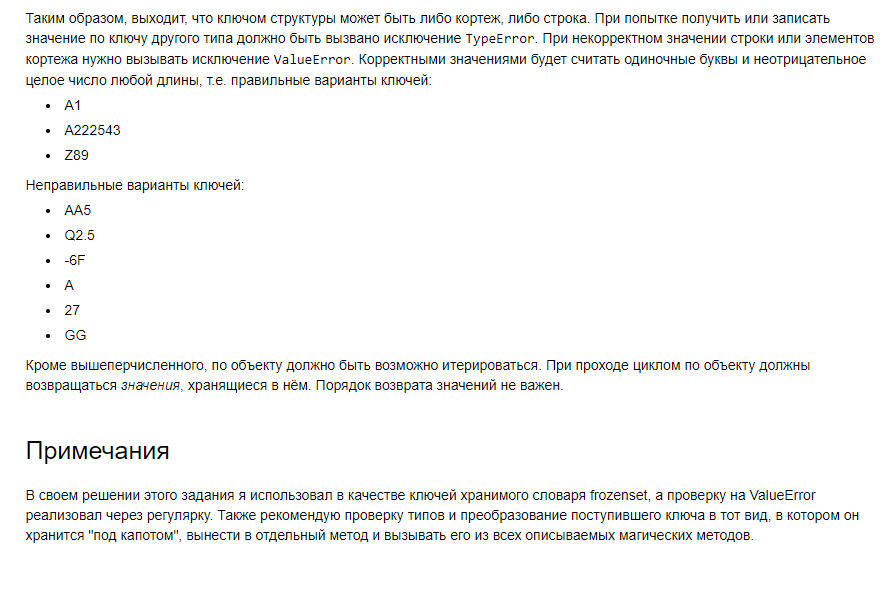

Версия №2 - рабочая (изменил структуру словаря)

In [ ]:
import re 

class Field(dict):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.keys_iter = set()
    self.counter_iter = 0

  def __getitem__(self, key):
    key = self.check_input(key)
    try:
      return super().__getitem__(key)
    except KeyError:
      return None

  def __setitem__(self, key, value):
    key = self.check_input(key)
    super().__setitem__(key, value)
    self.keys_iter.add(key)
      
  def __delitem__(self, key):
    key = self.check_input(key)
    super().__delitem__(key)
    self.keys_iter.remove(key)
        
  def __contains__(self, key):
    key = self.check_input_without(key)
    return super().__contains__(key)
  
  def __iter__(self):
    """Итератор"""
    return self

  def __next__(self):
    """След элемент итератора"""
    if self.counter_iter < len(self.values()):
      # если еще не перебрали все элементв
      result =  self.keys_iter.pop()
      self.counter_iter += 1
      return self.__getitem__(result)
    else:
      # если перебрали = обнулить счетчик и востонавить keys_iter
      self.counter_iter = 0
      self.keys_iter = set(self.keys())
      raise StopIteration
  
  def check_input(self, key):
    """ Приведние ключей к одному виду.
    Хотим привести все входы к "Буква-цифра" - "а1", "с999" 
    """
    
    # проверка типа входного значения и прведения к строке
    if isinstance(key, tuple):
      str_input = str(key[0]) + str(key[1])
    elif isinstance(key, str):
      str_input = key
    else:
      raise TypeError

    # изменение регистра на нижний
    str_input = str_input.lower()

    # ищем букву и цифру
    pattern_dw = r'(?:(^\d+)([a-z]{1}$))'
    findings_dw = re.findall(pattern_dw, str_input)
    pattern_wd = r'(?:(^[a-z]{1})(\d+$))'
    findings_wd = re.findall(pattern_wd, str_input)
    
    # проверки
    if len(findings_dw) == 0 and len(findings_wd) == 0:
      raise ValueError
    elif findings_wd:
      pass
    elif findings_dw:
      str_input = findings_dw[0][1]+findings_dw[0][0]

    return str_input

  def check_input_without(self, key):
    if isinstance(key, tuple):
      str_input = str(key[0]) + str(key[1])
    elif isinstance(key, str):
      str_input = key

    # изменение регистра на нижний
    str_input = str_input.lower()

    # ищем букву и цифру
    pattern_dw = r'(?:(^\d+)([a-z]{1}$))'
    findings_dw = re.findall(pattern_dw, str_input)
    pattern_wd = r'(?:(^[a-z]{1})(\d+$))'
    findings_wd = re.findall(pattern_wd, str_input)
    
    # проверки
    if findings_wd:
      pass
    elif findings_dw:
      str_input = findings_dw[0][1]+findings_dw[0][0]

    return str_input

field = Field()
field['f1']=1
field['b112']=2
field['b113'] # ничего не вернул на это значнеие т.к. его нет
for a in field:
  print(a)

del field['b112']
# field['b112']

field.__dict__

2
1


{'counter_iter': 0, 'keys_iter': {'f1'}}

Версия №1 - не прошал все тесты (писал сам структуру)

In [ ]:
import re 

class Field():
  def __init__(self):
    """Конструктор"""
    self.values = dict() # где храним значения
    self.counter_iter = 0 # счетчик итератора
    self.keys_iter = set() # ключи для итератора

  def __getitem__(self, key):
    """Получить значения"""
    key = self.check_input(key)
    if key not in self.values:
      raise ValueError
    else:
      return self.values[key]
  
  def __setitem__(self, key, value):
    """Установить значение"""
    key = self.check_input(key)
    self.values[key] = value
    self.keys_iter.add(key)
    
  def __delitem__(self, key):
    """Удалить элемент"""
    key = self.check_input(key)
    if key not in self.values:
      raise ValueError
    else:
      self.values.pop(key)
      self.keys_iter.remove(key)
        
  def __contains__(self, key):
    """Оператор in"""
    key = self.check_input(key)
    return key in self.values.keys()

  def __iter__(self):
    """Итератор"""
    return self

  def __next__(self):
    """След элемент итератора"""
    if self.counter_iter < len(self.values):
      # если еще не перебрали все элементв
      result =  self.keys_iter.pop()
      self.counter_iter += 1
      return self.__getitem__(result)
    else:
      # если перебрали = обнулить счетчик и востонавить keys_iter
      self.counter_iter = 0
      self.keys_iter = set(self.values.keys())
      raise StopIteration

  def check_input(self, key):
    """ Приведние ключей к одному виду.
    Хотим привести все входы к "Буква-цифра" - "а1", "с999" 
    """
    
    # проверка типа входного значения и прведения к строке
    if isinstance(key, tuple):
      str_input = str(key[0]) + str(key[1])
    elif isinstance(key, str):
      str_input = key
    else:
      raise ValueError

    # изменение регистра на нижний
    str_input = str_input.lower()

    # ищем букву и цифру
    pattern_dw = r'(?:(^\d+)([a-z]{1}$))'
    findings_dw = re.findall(pattern_dw, str_input)
    pattern_wd = r'(?:(^[a-z]{1})(\d+$))'
    findings_wd = re.findall(pattern_wd, str_input)
    
    # проверки
    if len(findings_dw) == 0 and len(findings_wd) == 0:
      raise TypeError
    elif findings_wd:
      pass
    elif findings_dw:
      str_input = findings_dw[0][1]+findings_dw[0][0]

    return str_input

Тест №1

In [ ]:
field = Field()

field['b', 123] = 155
field['b', 123],  field[123, 'b'], field['b', '123'], field['123', 'b'], field['b123'], field['123b']
# del field['b', 123]

(155, 155, 155, 155, 155, 155)

Тест №2

In [ ]:
field = Field()

field[1, 'a'] = 25
field[1, 'a']
field['a', 1] = 25
field['a', 1]
field['a', '1'] = 25
field['a', '1']
field['a', 123] = 25
field['a', 123]
field['1', 'a'] = 25
field['1', 'a']
field['1a'] = 25
field['1a']
field['a1'] = 25
field['a1']
field[1, 'A'] = 25
field[1, 'A']
field['A', 1] = 25
field['A', 1]
field['A', '1'] = 25
field['A', '1']
field['1', 'A'] = 25
field['1', 'A']
field['1A'] = 25
field['1A']
field['A1'] = 25
field['A1']
field.values

<function Field.values>

Тест №3

In [ ]:
(1, 'a') in field, "A1" in field, ('D', '4') in field # T, T, F

(True, True, False)

Тест №4

In [ ]:
# correct keys
field['A1'] = 1
field['A1']
field['A222543'] = 222543
field['A222543']
field['Z89'] = 89
field['Z89']

89

In [ ]:
# # incorrect keys

# field['AA5'] = 5 #false
# field['AA5']
# field['Q2.5'] = 2.5
# field['Q2.5']
# field['-6F'] = -6
# field['-6F'] 
# field['A'] = 0
# field['A']
# field['27'] = 27
# field['27']
# field['GG'] = 28
# field['GG']

Тест №5

In [ ]:
for value in field:
  print(value)
for value in field:
  print(value)

89
222543
25
1
89
222543
25
1


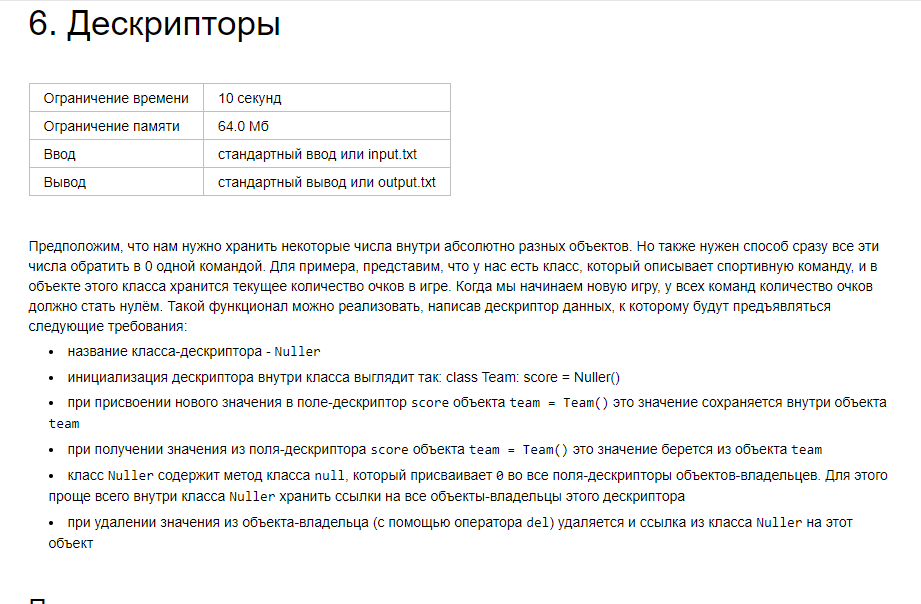

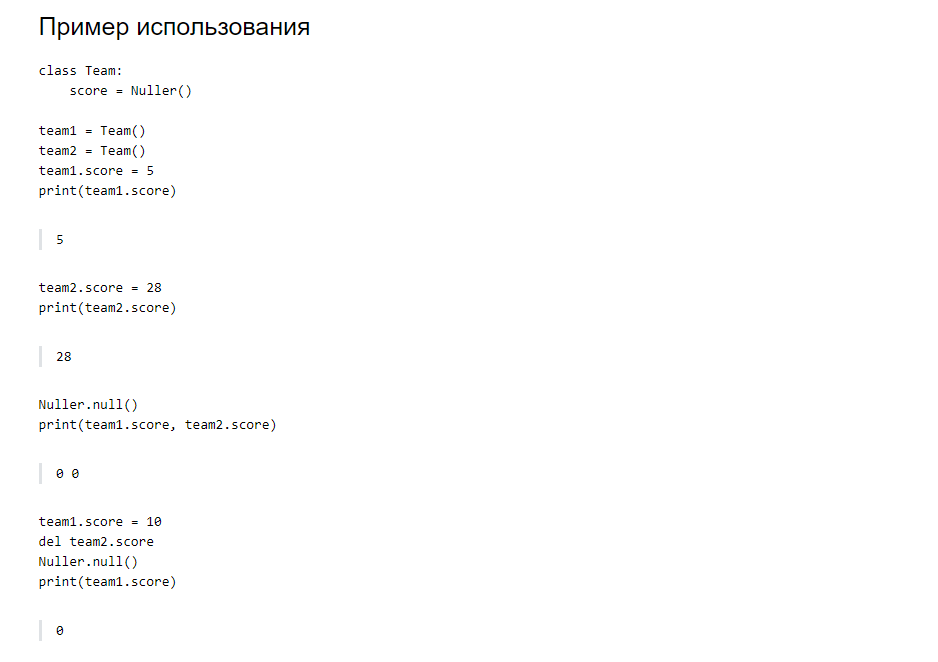

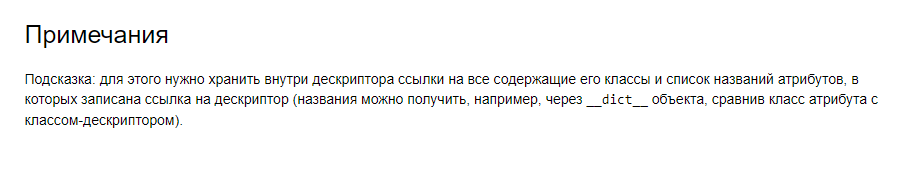

In [ ]:
# как достать имя - версия 1
class Enum:
    A = 1
    B = 2

for a in Enum.__dict__:
  if Enum.__dict__[a] == 1:
    print(a)

A


Решение версия 3

In [ ]:
class Nuller:
  list_owners = []

  def __set_name__(self, owner_outside, name):
    self.name = name

  def __set__(self, owner, var): 
    if {owner:self.name} not in self.list_owners:
      self.list_owners.append({owner:self.name})
    owner.__dict__[self.name] = var

  def __get__(self, owner, owner_cls):
    return owner.__dict__[self.name]

  def __delete__(self, owner):
    del owner.__dict__[self.name]
    self.list_owners.remove({owner:self.name})

  @classmethod
  def null(cls):
    for pare in cls.list_owners:
      for owner, name in pare.items():
        owner.__dict__[name] = 0
        

class Team:
  MIPT1 = Nuller()
  MIPT2 = Nuller()
t = Team()
t.MIPT1 = 3
t.MIPT2 = 3

Nuller.null()

t.MIPT1, t.MIPT2

(3, 3)

In [ ]:
t2.MIPT = 1
t1.MIPT = 1
t1.MIPT, t2.MIPT, t3.MIPT

(1, 1, 3)

Тесты


In [ ]:
class Team:
    score = Nuller()

team1 = Team()
team2 = Team()
team1.score = 5
print(team1.score) #5

team2.score = 28
print(team2.score) #28

Nuller.null()
print(team1.score, team2.score) #0 0

team1.score = 10
del team2.score
Nuller.null()
print(team1.score) #0

5
28
0 0
0


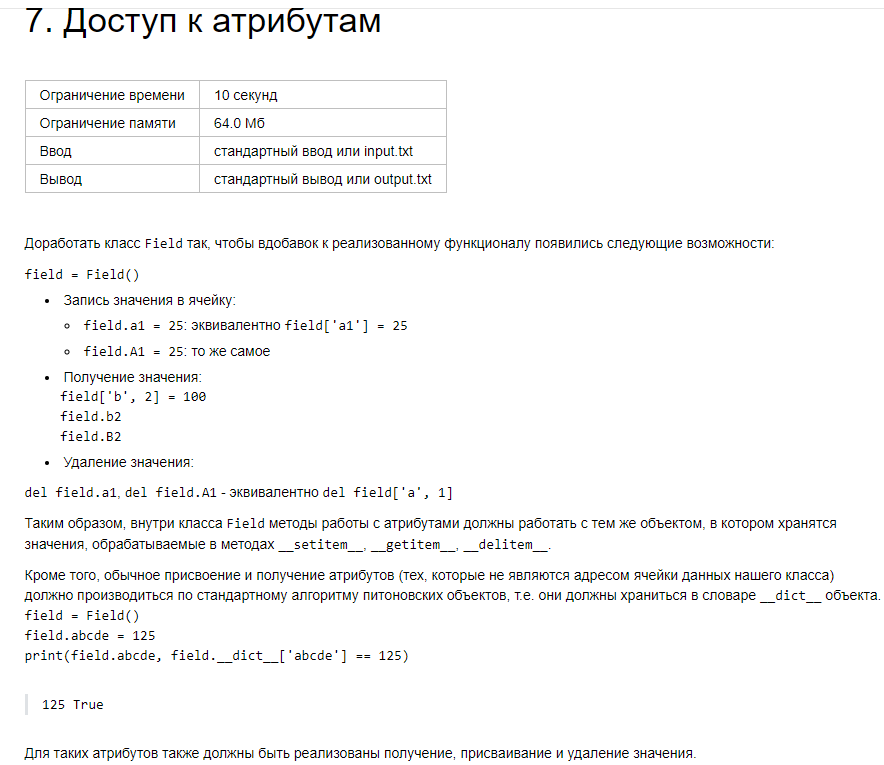

Решение:

In [ ]:
import re 

class Field(dict):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.keys_iter = set()
    self.counter_iter = 0

  def __getattr__(self, key):
    if self.check_input(key):
      return self.__getitem__(key)
    else:
      return super().__getattr__(key)

  def __setattr__(self, key, val):
    if self.check_input(key):
      return self.__setitem__(key, val)
    else:
      return super().__setattr__(key, val)

  def __delattr__(self, key):
    if self.check_input(key):
      return self.__delitem__(key)
    else:
      return super().__delattr__(key)

  def __getitem__(self, key):
    key = self.process_input(key)
    try:
      return super().__getitem__(key)
    except KeyError:
      return None

  def __setitem__(self, key, value):
    key = self.process_input(key)
    super().__setitem__(key, value)
    self.keys_iter.add(key)
      
  def __delitem__(self, key):
    key = self.process_input(key)
    super().__delitem__(key)
    self.keys_iter.remove(key)
        
  def __contains__(self, key):
    try:
      key = self.process_input(key)
    except (TypeError, ValueError):
      pass
    finally:
      return super().__contains__(key)
  
  def __iter__(self):
    """Итератор"""
    return self

  def __next__(self):
    """След элемент итератора"""
    if self.counter_iter < len(self.values()):
      # если еще не перебрали все элементв
      result =  self.keys_iter.pop()
      self.counter_iter += 1
      return self.__getitem__(result)
    else:
      # если перебрали = обнулить счетчик и востонавить keys_iter
      self.counter_iter = 0
      self.keys_iter = set(self.keys())
      raise StopIteration
  
  def check_input(self, key): 
    """Проверим на верность тип входа и формат входа"""
    try:
      key = self.process_input(key)
      return True
    except (TypeError, ValueError):
      return False

  def __correct_type(self, key):
      # приведение к нужному типу
    if isinstance(key, tuple):
      str_input = str(key[0]) + str(key[1])
    elif isinstance(key, str):
      str_input = key
    else:
      raise TypeError
    return str_input

  def __find_letter_and_digit(self, str_input):
    # изменение регистра на нижний
    str_input = str_input.lower()

    # ищем букву и цифру
    pattern_dw = r'(?:(^\d+)([a-z]{1}$))'
    findings_dw = re.findall(pattern_dw, str_input)
    pattern_wd = r'(?:(^[a-z]{1})(\d+$))'
    findings_wd = re.findall(pattern_wd, str_input)
    
    # проверки
    if len(findings_dw) == 0 and len(findings_wd) == 0:
      raise ValueError
    elif findings_wd:
      letter = findings_wd[0][0]
      digit = findings_wd[0][1]
    elif findings_dw:
      letter = findings_dw[0][1]
      digit = findings_dw[0][0]
    
    return letter+digit


  def process_input(self, key):
    """ Приведние ключей к одному виду.
    Хотим привести все входы к "Буква-цифра" - "а1", "с999" 
    """
    # проверка типа входного значения и приведения к строке
    str_input = self.__correct_type(key)

    # найдем букву и цифру и вернеме букву-цифру ("а1","d3"...)
    str_out = self.__find_letter_and_digit(str_input)

    return str_out

{'counter_iter': 0, 'keys_iter': {'a1', 'b112', 'f1'}, 'str_': 1}

Тест №1

In [ ]:

field = Field()
field['f1']=1
field['b112']=2
field['b113']
# for a in field:
#   print(a)

field.f1 = 2
field.f1
# del field.f1
# field.f1

field.a1 = 25
field.a1
field['a1']
field.__dict__
# del field['a', 1]
# field.__dict__

field.str_ = 1
field.__dict__

Тест №2

In [ ]:
'f1' in field

True

Тест №3

In [ ]:
field = Field()

field.a1 = 25 # : эквивалентно field['a1'] = 25
field.A1
del field.a1

field.A1 = 25 #: то же самое
field.a1
del field.A1

field['b', 2] = 100
field.b2
field.B2

field.a1 = 25
del field.a1
field.a1 = 25
del field.A1
field.a1 = 25
del field['a', 1]

field = Field()
field.abcde = 125
print(field.abcde, field.__dict__['abcde'] == 125)

125 True


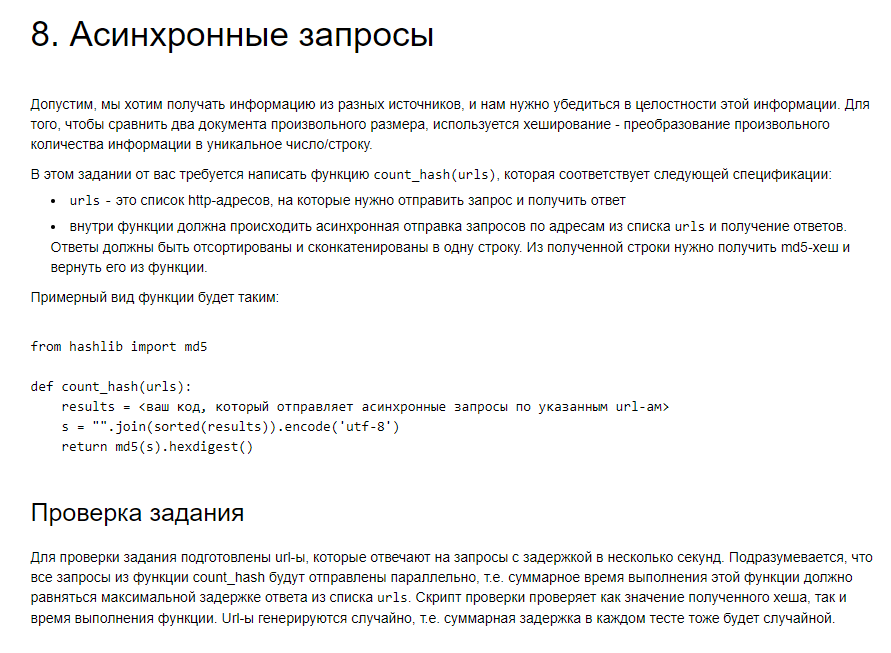

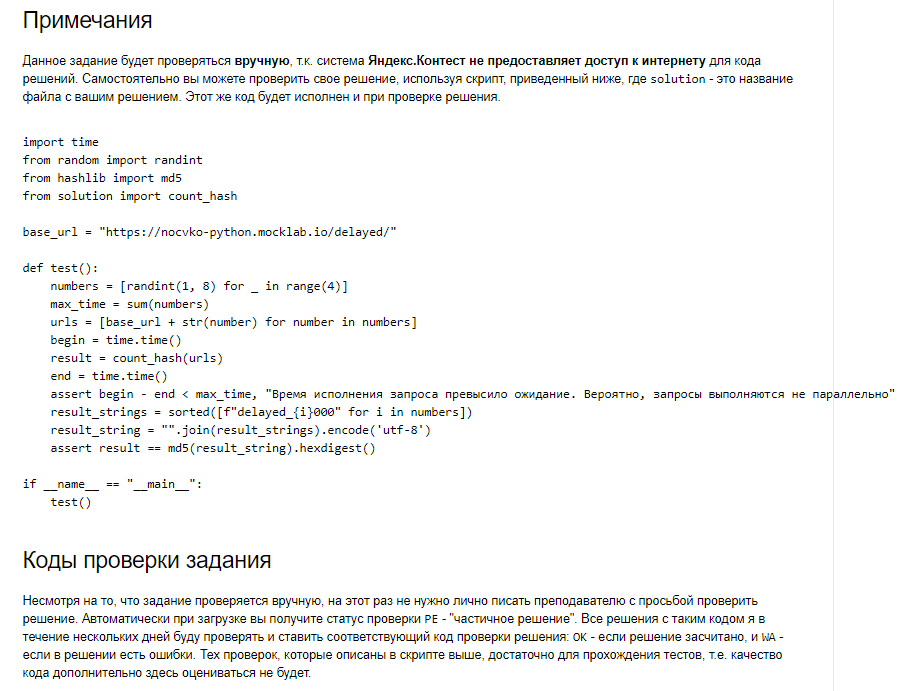

In [ ]:
import time
import asyncio
from hashlib import md5
import aiohttp
import time
from random import randint
from hashlib import md5
from aiohttp import ClientSession


# мои тестовые данные
urls = ["http://python.org", "http://microsoft.com", "http://python.org"]
base_url = "https://nocvko-python.mocklab.io/delayed/"
numbers = [randint(1, 8) for _ in range(4)]
urls = [base_url + str(number) for number in numbers]


async def make_request(url):
    """Делает 1 запрос на сайт"""
    async with aiohttp.request('GET', url) as response:
        r = await response.json() # преобразуем в json
        return r['message'] # вытащим поле message из json


async def make_many_requests(urls):
    """Делаем несколько асинхр запросов"""
    tasks = [] # лист задача
    for url in urls:
        task = asyncio.ensure_future(make_request(url)) # создали задачу и обрнули ее в крутину
        tasks.append(task)
    results = await asyncio.gather(*tasks) # запустили параельно задачи
    return results

def count_hash(urls):
    """Главная функция"""
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    results = loop.run_until_complete(make_many_requests(urls))

    s = "".join(sorted(results)).encode('utf-8')
    return md5(s).hexdigest()


## Тест 1 - через главную функцию
# count_hash(urls)

## Тест 2 - запускал до этого так
# loop = asyncio.new_event_loop()
# asyncio.set_event_loop(loop)
# # tasks = [loop.create_task(make_request("https://nocvko-python.mocklab.io/delayed/1"))]
# # loop.run_until_complete(asyncio.wait(tasks))
# loop.run_until_complete(count_hash(urls))

## Тест 3
base_url = "https://nocvko-python.mocklab.io/delayed/"
def test():
    numbers = [randint(1, 8) for _ in range(4)]
    max_time = sum(numbers)
    urls = [base_url + str(number) for number in numbers]
    begin = time.time()
    result = count_hash(urls)
    end = time.time()
    assert begin - end < max_time, "Время исполнения запроса превысило ожидание. Вероятно, запросы выполняются не параллельно"
    result_strings = sorted([f"delayed_{i}000" for i in numbers])
    result_string = "".join(result_strings).encode('utf-8')
    assert result == md5(result_string).hexdigest()

if __name__ == "__main__":
    test()

Литература

https://habr.com/ru/post/337420/
https://www.twilio.com/blog/asynchronous-http-requests-in-python-with-aiohttp
https://tonais.ru/library/asinhronnoe-programmirovanie-dlya-veb-razrabotki-v-python
https://telegra.ph/Oshibki-v-botah-i-kak-ih-chitat-01-11
https://docs-python.ru/standart-library/modul-asyncio-python/funktsii-obekt-future-modulja-asyncio/
https://ericplayground.com/2018/10/17/making-async-http-requests-with-python-aiohttp/

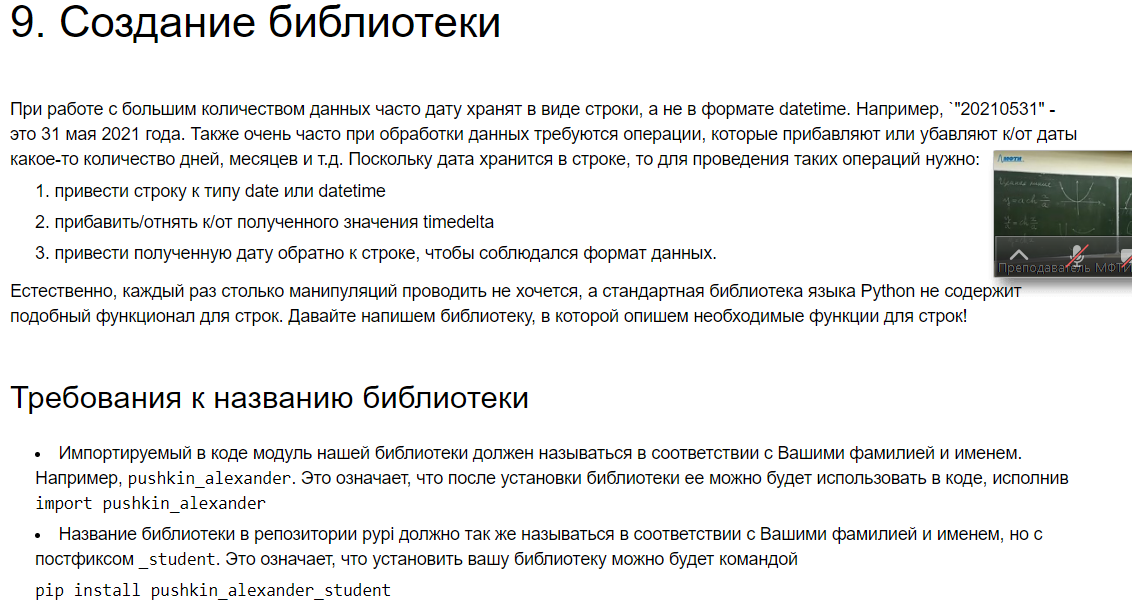

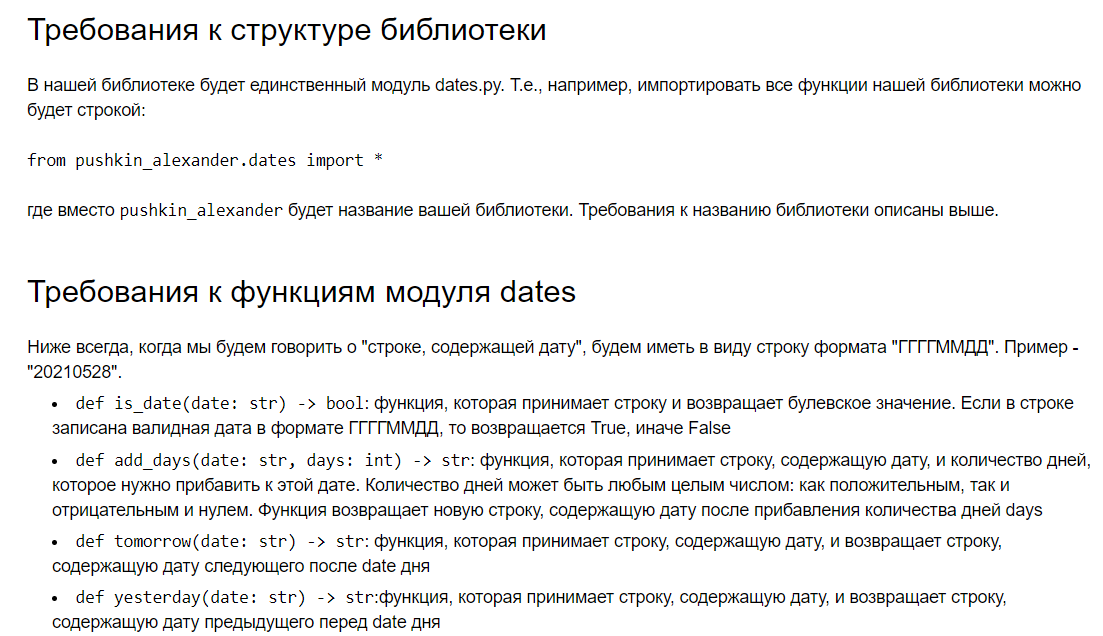

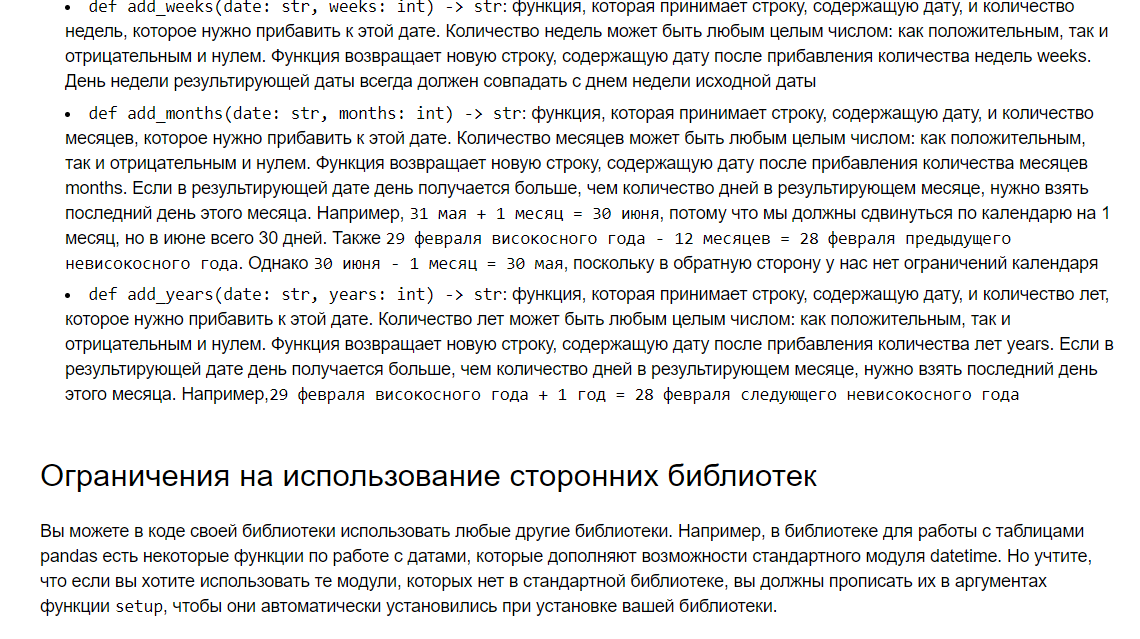

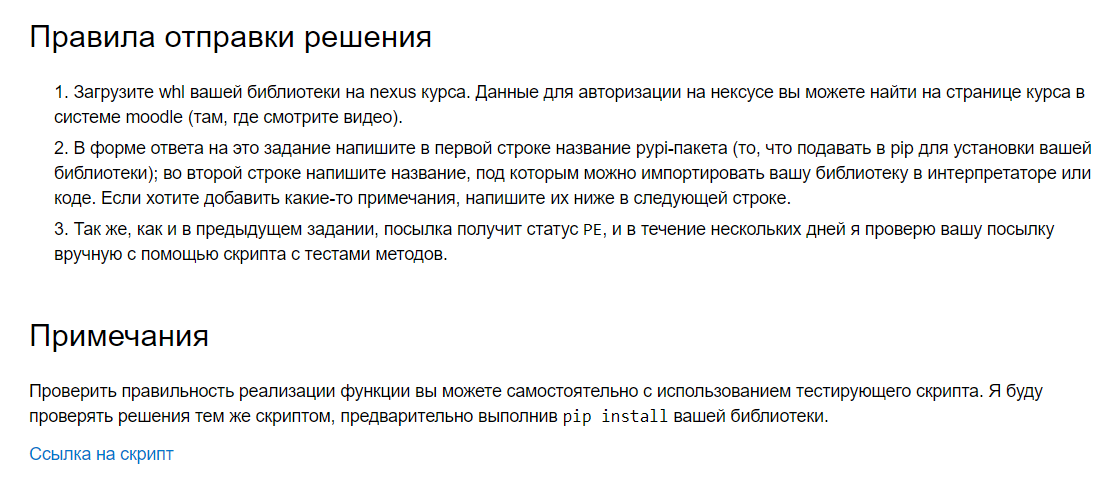

In [ ]:
c = datetime.date(2021, 1, 1) + datetime.timedelta(days = -1)
c.day, c.month, c.year


(31, 12, 2020)

In [ ]:
import datetime
import calendar 
from dateutil.relativedelta import relativedelta 

def __pars_data_up(date):
  """Переводит строку в объект datetime"""
  if is_date(date):
    year = int(date[0:4])
    month = int(date[4:6])
    day = int(date[6:8])
    return datetime.date(year, month, day)

def __pars_data_down(date_dt):
  """Переводит объект datetime в строку"""
  year = str(date_dt.year)
  month = str(date_dt.month)
  if len(month) == 1:
    month = "0" + month;
  day = str(date_dt.day)
  if len(day) == 1:
    day = "0" + day;
  return year + month + day

def is_date(date: str) -> bool:
  """
  Проверяет является ли дата валидной.
  1 - проверяет тип данных,
  2 - проверяет кол-во дней и месяцев (встроенов в datetime).
  """
  if not isinstance(date, str):
    # raise ValueError('На вход нужно строку')
    return False
  try:
    year = int(date[0:4])
    month = int(date[4:6])
    day = int(date[6:8])
    datetime.date(year, month, day)
  except ValueError:
    # raise ValueError("Неверное количество дней в году или неверный месяц")
    return False 

  return True

def add_days(date: str, days: int) -> str:
  """Добавляет days дней к дате date"""
  data_dt = __pars_data_up(date)
  delta = datetime.timedelta(days = days)
  result_data_dt = data_dt + delta
  return __pars_data_down(result_data_dt)

def tomorrow(date: str) -> str:
  """Добавляет +1 день к дате date"""
  return add_days(date, 1)

def yesterday(date: str) -> str:
  """Добавляет -1 день к дате date"""
  return add_days(date, -1)

def add_weeks(date: str, weeks: int) -> str:
  """Добавляет weeks недель к дате date"""
  return add_days(date, 7*weeks)

def add_months(date: str, months: int) -> str:
  """
  Добавляет months месяцов к дате date.
  Добавление идет не по дням а по месяцам с приведением дней.
  """
  data_dt = __pars_data_up(date)
  delta = relativedelta(months=months)
  result_data_dt = data_dt + delta
  return __pars_data_down(result_data_dt)

def add_years(date: str, years: int) -> str:
  """
  Добавляет months месяцов к дате date.
  Добавление идет не по дням а по месяцам с приведением дней.
  """
  data_dt = __pars_data_up(date)
  delta = relativedelta(years=years)
  result_data_dt = data_dt + delta
  return __pars_data_down(result_data_dt)


is_date('20200229')
add_days('20200229', 1)
tomorrow('20200229')
add_weeks('20200229', 1)
add_months('20200229', 1)
add_years('20200229', 1)

'20210228'

datetime.date(2020, 2, 29)

In [ ]:
import datetime
import calendar
from dateutil.relativedelta import relativedelta 
# https://askdev.ru/q/kak-dobavit-3-mesyaca-v-datetime-obekt-daty-v-python-143295/ 

calendar.monthrange(2021, 2)

some_date = datetime.date.today()
some_date
relativedelta(months=1)

relativedelta(months=+1)

In [ ]:
def test_is_date():
    assert is_date("20200101") == True, "is_date != True for '20200101'"
    assert is_date("20201313") == False, "is_date != False for '20201313'"
    assert is_date("20200229") == True, "is_date != True for '20200229'"
    assert is_date("20210229") == False, "is_date != False for '20210229'"


def test_add_days():
    assert add_days("20200401", 5) == "20200406", "add_days('20200401', 5) != '20200406'"
    assert add_days("20200401", 0) == "20200401", "add_days('20200401', 0) != '20200401'"
    assert add_days("20200401", -2) == "20200330", "add_days('20200401', -2) != '20200330'"
    assert add_days("20200401", 365 * 2) == "20220401", "add_days('20200401', 365*2) != '20220401'"
    assert add_days("20200401", -365 * 2) == "20180402", "add_days('20200401', -365 * 2) != '20180402'"


def test_tomorrow():
    assert tomorrow("20200401") == "20200402", "tomorrow('20200401') != '20200402'"
    assert tomorrow("20200331") == "20200401", "tomorrow('20200331') != '20200401'"
    assert tomorrow("20201231") == "20210101", "tomorrow('20201231') != '20210101'"
    assert tomorrow("20200228") == "20200229", "tomorrow('20200228') != '20200229'"
    assert tomorrow("20200229") == "20200301", "tomorrow('20200229') != '20200301'"


def test_yesterday():
    assert yesterday("20200402") == "20200401", "yesterday('20200402') != '20200401'"
    assert yesterday("20200401") == "20200331", "yesterday('20200401') != '20200331'"
    assert yesterday("20210101") == "20201231", "yesterday('20210101') != '20201231'"
    assert yesterday("20200229") == "20200228", "yesterday('20200229') != '20200228'"
    assert yesterday("20200301") == "20200229", "yesterday('20200301') != '20200229'"


def test_add_weeks():
    assert add_weeks("20200401", 3) == "20200422", "add_weeks('20200401') != '20200422'"
    assert add_weeks("20200401", 0) == "20200401", "add_weeks('20200401') != '20200401'"
    assert add_weeks("20200401", -5) == "20200226", "add_weeks('20200401', -5) != '20200226'"
    assert add_weeks("20200401", 52) == "20210331", "add_weeks('20200401', 52) != '20210331'"
    assert add_weeks("20200401", -53) == "20190327", "add_weeks('20200401', -53) != '20190327'"


def test_add_months():
    cases = (
        ("20200401", 1, "20200501"),
        ("20200401", 0, "20200401"),
        ("20200401", -1, "20200301"),
        ("20200428", -3, "20200128"),
        ("20200128", 3, "20200428"),
        ("20200131", 1, "20200229"),
        ("20190228", 12, "20200228"),
        ("20210228", -12, "20200228"),
        ("20200229", 12, "20210228"),
        ("20200229", -12, "20190228"),
        ("20200229", 48, "20240229"),
        ("20200229", -48, "20160229"),
    )
    for case in cases:
        assert add_months(case[0], case[1]) == case[2], f"add_months('{case[0]}', {case[1]}) != '{case[2]}'"


def test_add_years():
    cases = (
        ("20200401", 1, "20210401"),
        ("20200401", 0, "20200401"),
        ("20200401", -1, "20190401"),
        ("19990401", 2, "20010401"),
        ("20000401", -3, "19970401"),
        ("20200229", 1, "20210228"),
        ("20200229", -1, "20190228"),
        ("20190228", 1, "20200228"),
        ("20210228", -1, "20200228"),
    )
    for case in cases:
        assert add_years(case[0], case[1]) == case[2], f"add_months('{case[0]}', {case[1]}) != '{case[2]}'"


test_is_date()
test_yesterday()
test_tomorrow()
test_add_days()
test_add_weeks()
test_add_months()
test_add_years()